In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    Binarizer,
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [132]:
# marche pas avec un xls il faut le convertir en xlsx
data = pd.read_excel("titanic3.xlsx")
data_df = data.copy()


survival - Survival (0 = No; 1 = Yes)\
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)\
name - Name\
sex - Sex\
age - Age\
sibsp - Number of Siblings/Spouses Aboard\
parch - Number of Parents/Children Aboard\
ticket - Ticket Number\
fare - Passenger Fare\
cabin - Cabin\
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)\
boat - Lifeboat (if survived)\
body - Body number (if did not survive and body was recovered)

In [133]:
data_df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


# phase de préprocessing 

In [134]:
data_df.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [135]:
data_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [136]:
total_people = data_df["survived"].count()
print("Total people: ", total_people)
total_dead_people = data_df["survived"].value_counts()[0]
print("Total dead people: ", total_dead_people)
total_survived_people = data_df["survived"].value_counts()[1]
print("Survived people: ", total_survived_people)
print("total dead ratio : ", total_dead_people / total_people * 100)


Total people:  1309
Total dead people:  809
Survived people:  500
total dead ratio :  61.80290297937356


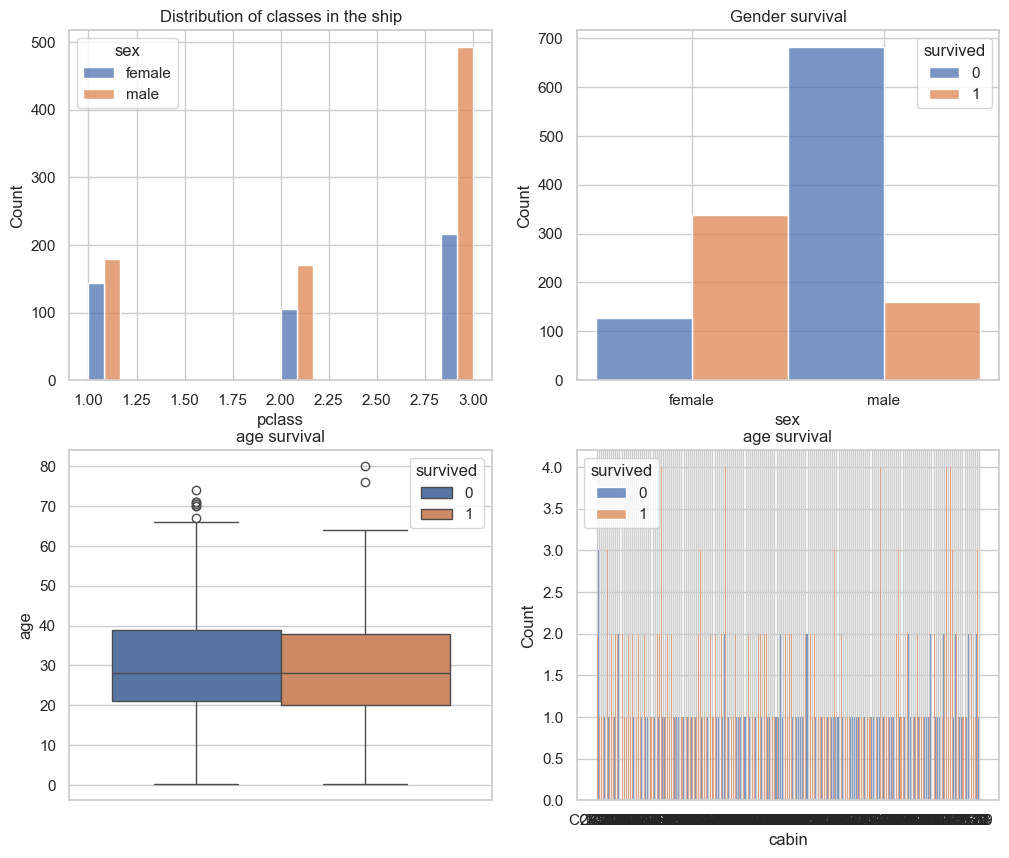

In [137]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Premier sous-graphe
sns.histplot(x="pclass", data=data_df, ax=axes[0, 0], hue="sex", multiple="dodge")
axes[0, 0].set_title("Distribution of classes in the ship")

# Deuxième sous-graphe
sns.histplot(x="sex", data=data_df, ax=axes[0, 1], hue="survived", multiple="dodge")
axes[0, 1].set_title("Gender survival")

# # Troisième sous-graphe
# sns.boxplot(x="sex", y="survived", data=data_df, color="green", ax=axes[1, 0])
# axes[0, 1].set_title("Gender survival")
# # Troisième sous-graphe
sns.boxplot(y="age", data=data_df, ax=axes[1, 0], hue="survived")
axes[1, 0].set_title("age survival")

# Quatrième sous-graphe
sns.histplot(x="cabin", data=data_df, hue="survived", ax=axes[1, 1], multiple="dodge")
axes[1, 1].set_title("age survival")


# Afficher la figure
plt.show()


In [138]:
# sns.pairplot(data_df, hue="survived")

In [139]:
# Identifier les variables quantitatives (numériques)
quantitative_features = data_df.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

# Identifier les variables qualitatives (catégorielles)
qualitative_features = data_df.select_dtypes(include=["object"]).columns.tolist()

print("Variables Quantitatives:", quantitative_features)
print("Variables Qualitatives:", qualitative_features)


Variables Quantitatives: ['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'body']
Variables Qualitatives: ['name', 'sex', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest']


# indentification des features et de la target

In [140]:
y = data_df["survived"]

X = data_df.drop("survived", axis=1)


# Analyse du preprocessing 
* sex => encodage one hot encoder car 2 possibilité (male/female)
* embarked => encodage one hot encoder car 3 possibilité (S/C/Q)
* ticket => ordinal encoder car 939 value distinctes 
* name => on en a pas vraiment besoin donc on peut l'enlever
* age => on remplace les missing values par la moyenne des age (pour ne pas perdre trop d'info)
* cabin => 77% de missing values donc peu de valeur on peut l'enlever aussi
* boat => 63% de missing values MAIS ca représente les gens secourus donc on garde  et on a va fillna avec une valeur outliers genre-1 et puis on encode avec un encoder (ordinal) 
* home destination => peu d'intérêts 
* body => encore beacoup de missing, ceux qu'on a secouru et ceux qu'on a jamais retrouvé , on pourrais fillna à 2 valeurs différentes  en fonction de si on l'a secouru ou pas 


In [141]:
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [142]:
X2 = X.drop(columns=["name", "home.dest", "cabin", "boat", "body", "ticket"])
# X2["ticket"]=X2["ticket"].str.extract(r'(\d+)').astype(float)


# Creation du train test

In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42
)


# Création de pipeline

In [ ]:
sex_ticket_pipe = make_pipeline(OneHotEncoder(drop="first"))

age_fare_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

embarked_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(drop="first")
)

transformer = make_column_transformer(
    (sex_ticket_pipe, ["sex"]),
    (age_fare_pipe, ["age", "fare"]),
    (embarked_pipe, ["embarked"]),
    remainder="passthrough",
)


In [ ]:
# model = make_pipeline(transformer, SVC())

In [ ]:
model = make_pipeline(transformer, RandomForestClassifier(n_estimators=300))
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.7977099236641222

In [147]:
model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(drop='first'))]),
                                    ['sex']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['age', 'fare']),
                                   ('pipeline-3',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                

In [148]:
model.score(X_train, y_train)

0.9713467048710601

In [149]:
model.score(X_test, y_test)

0.7977099236641222

In [150]:
paramsrfc = {
    "randomforestclassifier__max_depth": [50, 100, 150, 200],
    "randomforestclassifier__criterion": ["gini", "entropy"],
}

gridrfc = GridSearchCV(model, paramsrfc, cv=5, scoring="accuracy")
finalrfcmodel = gridrfc.fit(X_train, y_train)
finalrfcmodel.score(X_test, y_test)


0.7977099236641222

In [ ]:
# params2 = {"svc__degree": [1, 2, 3, 4, 5]}
# grid = GridSearchCV(estimator=model, param_grid=params2, cv=5, scoring="accuracy")
# # ici on utilise pas les DecisionTreeClassifier car on a défini un SVC plus haut dans le pipeline
# # cv = cross validation en gros il va faire l'entrainement sur 5 jeu de données




In [152]:
# model = grid.fit(X_train, y_train)

In [ ]:
model = finalrfcmodel

In [153]:
# grid.best_params_

In [159]:
model.score(X_test, y_test)

0.7977099236641222

In [ ]:
y_pred_pipeline = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_pipeline)


<Axes: >

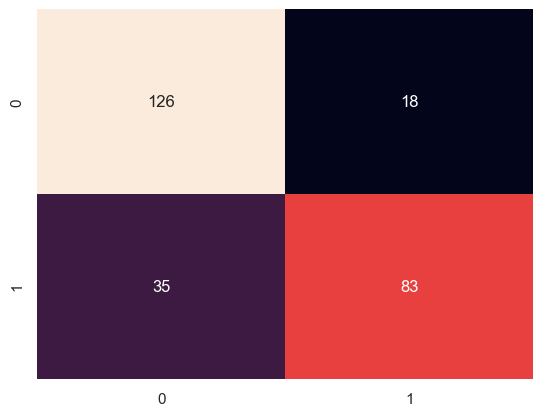

In [ ]:
sns.heatmap(
    confusion_matrix(y_test, y_pred_pipeline), annot=True, cbar=False, fmt=".3g"
)
